In [1]:
# Reference: https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8
import os
import numpy as np
np.random.seed(251)
os.environ['PYTHONHASHSEED']=str(251)
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
project_path = r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project'
dir_openpose = 'openpose_output'
# old
# dir_train = 'train_optical_flow_output_transfer'
dir_train = 'NEW4_image_transfer_trial3'
dir_test = 'NEW4_manual_optical_flow_output_trial3'
model_name = 'ResNet50_model_weights_NEW4_trial3.h5'
TRAIN_DIR = os.path.join(project_path, dir_openpose, dir_train)
class_list = ['AGAIN', 'ALL', 'AWKWARD', 'BASEBALL', 'BEHAVIOR', 'CAN', 'CHAT', 'CHEAP', 
              'CHEAT', 'CHURCH', 'COAT', 'CONFLICT', 'COURT', 'DEPOSIT', 'DEPRESS', 
              'DOCTOR', 'DRESS', 'ENOUGH', 'NEG']

HEIGHT = 300
WIDTH = 300

FC_LAYERS = []
dropout = 0.5
BATCH_SIZE = 8
NUM_EPOCHS = 10
num_train_images = len([f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
                        if 'train' in f])
print(num_train_images)

1155


In [3]:
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

# Reference: https://keras.io/preprocessing/image/
# Reference: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # Below are the parameters used for crop
    # zoom_range=[0.8, 1.2], 
    # width_shift_range=[-50,50]
    # Below are the parameters used for no crop
    zoom_range=[0.7, 1.3], 
    # width shift means up and down
    width_shift_range=0.2,
    height_shift_range = 0.2
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

C:\Users\Angela\Anaconda3\envs\w251_project3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 1155 images belonging to 19 classes.


In [4]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [5]:
adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])
finetune_model.summary()
filepath=os.path.join(project_path, model_name)
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

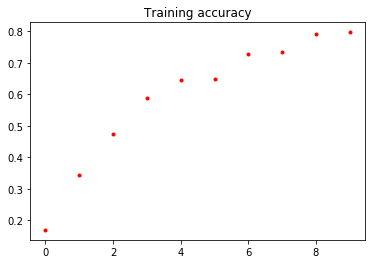

In [6]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.title('Training accuracy')
    plt.show()

plot_training(history)


In [7]:
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
model_saved = load_model(os.path.join(project_path, model_name))
# model_saved = finetune_model
def conv_index_to_vocab(ind):
    temp_dict = dict(enumerate(class_list))
    return temp_dict[ind]
def conv_vocab_to_index(vocab):
    temp_dict = dict(zip(class_list,range(len(class_list))))
    return temp_dict[vocab]

print(conv_index_to_vocab(0))
print(conv_vocab_to_index('NEG'))

AGAIN
18


In [9]:
count = 0
test_files_lst = [f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
                  if 'test' in f and 'sim0' in f]
for file in test_files_lst:
    img = image.load_img(os.path.join(project_path,dir_openpose, dir_test,file), target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    y_pred = model_saved.predict(x)
    print('-----------------')
    print('Actual: ', file.split('_')[1])
    print('Prediction: ', conv_index_to_vocab(np.argmax(y_pred)))
    if file.split('_')[1] == conv_index_to_vocab(np.argmax(y_pred)):
        count += 1 

-----------------
Actual:  AGAIN
Prediction:  DEPRESS
-----------------
Actual:  ALL
Prediction:  DEPRESS
-----------------
Actual:  AWKWARD
Prediction:  AWKWARD
-----------------
Actual:  BASEBALL
Prediction:  DEPRESS
-----------------
Actual:  BEHAVIOR
Prediction:  CONFLICT
-----------------
Actual:  CAN
Prediction:  DEPRESS
-----------------
Actual:  CHAT
Prediction:  CAN
-----------------
Actual:  CHAT
Prediction:  DEPRESS
-----------------
Actual:  CHEAP
Prediction:  DEPRESS
-----------------
Actual:  CHEAT
Prediction:  DEPRESS
-----------------
Actual:  CHEAT
Prediction:  DEPRESS
-----------------
Actual:  CHURCH
Prediction:  DEPRESS
-----------------
Actual:  COAT
Prediction:  DEPRESS
-----------------
Actual:  COAT
Prediction:  DEPRESS
-----------------
Actual:  CONFLICT
Prediction:  DEPRESS
-----------------
Actual:  COURT
Prediction:  CAN
-----------------
Actual:  DEPOSIT
Prediction:  DEPRESS
-----------------
Actual:  DEPRESS
Prediction:  DEPRESS
-----------------
Actual:  

In [10]:
print(count)
print(len(test_files_lst))


2
23
